In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [4]:
# create engine to hawaii.sqlite
Base = automap_base()
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
inspector = inspect(engine)

In [10]:
#Finding the columns and primary keys in measurement
columns = inspector.get_columns('measurement')

for column in columns:
    primarykeystr = ""
    if column ['primary_key']==1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [11]:
#Finding columns in station 
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


In [12]:
# Calculate the date one year from the last date in data set.
earliest = session.query(measurement.date).order_by(measurement.date).first()
latest= session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"Earliest: {earliest[0]} , Latest: {latest[0]}")

Earliest: 2010-01-01 , Latest: 2017-08-23


In [13]:
# Calculate the date 1 year ago from the last data point in the database
# The .strptime() method creates a datetime object from the given string
latestdate = dt.datetime.strptime(latest[0], '%Y-%m-%d')

querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date,measurement.prcp]
queryresult = session.query(*sel).filter(measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any')
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


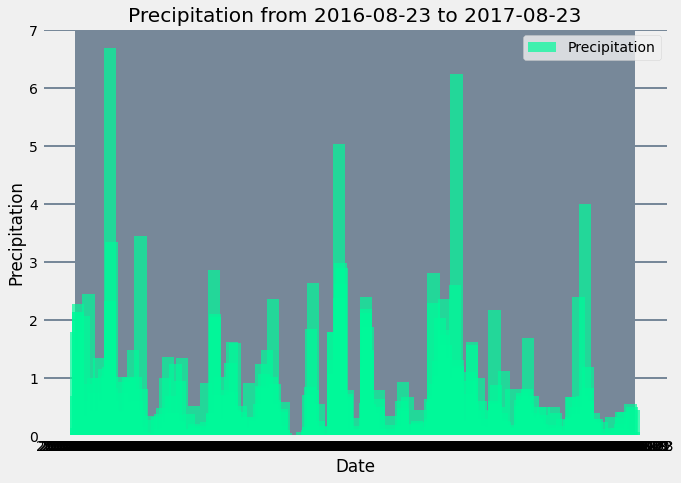

In [15]:
# Using Pandas Plotting with Matplotlib to plot the data
# tolist(), used to convert the data elements of an array into a list.

Date = precipitation.index.tolist()
Precipitation = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(Date,Precipitation,width = 8 ,color='mediumspringgreen', alpha=0.7, align="center",label='Precipitation')

plt.title(f"Precipitation from {querydate} to {latest[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', color='lightslategrey', linestyle='-', linewidth=2)
plt.legend()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
session.query(station.id).count()

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
select_stations = [station.station, measurement.station,func.count(measurement.id)]
select_stations
# List the stations and the counts in descending order.
activestations = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
activestations

# #clean dataframe by replacing null values with "0"
activestations_df = pd.DataFrame(activestations, columns=['Station','Station Activity']).fillna(0)
activestations_df

,Station,Station Activity
0,2010-01-01,0.15
1,2010-01-01,0.08
2,2010-01-01,0.28
3,2010-01-01,0.15
4,2010-01-01,0.14
5,2010-03-01,0.01
6,2010-01-01,0.05
7,2010-05-03,0.00
8,2010-01-01,0.21


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
measurments_select = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]

measurement_summary = session.query(*measurments_select).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
measurement_summary

(54.0, 85.0, 71.66378066378067)

In [20]:
session.query(measurement.station, func.count(measurement.tobs)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
sel = [measurement.station,measurement.tobs]

queryresult = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= querydate).all()

queryresult


stations_info = pd.DataFrame(queryresult, columns=['Tobs'])
stations_info

,Tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


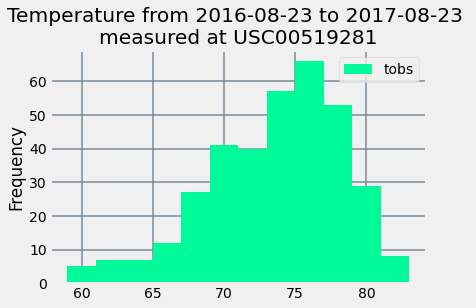

In [34]:
# matplotlib.pyplot.hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)

plt.hist(stations_info["Tobs"], bins=12,rwidth=1.0,label='tobs', color='mediumspringgreen')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.grid(which='major', axis='both', color='lightslategrey', linestyle='-', linewidth=2)
plt.title(f"Temperature from {querydate} to {latest[0]} \nmeasured at USC00519281")
plt.legend()

# Close session

In [23]:
# Close Session
session.close()